In [140]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/Kannada-MNIST/sample_submission.csv
/kaggle/input/Kannada-MNIST/Dig-MNIST.csv
/kaggle/input/Kannada-MNIST/train.csv
/kaggle/input/Kannada-MNIST/test.csv


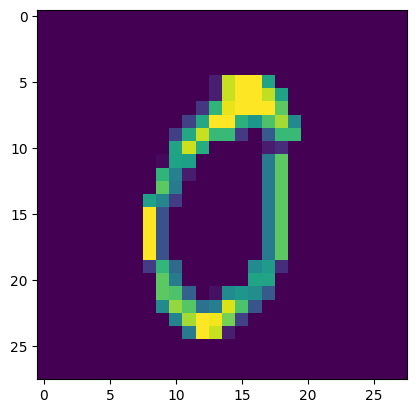

In [159]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#Loading the training dataset and converting it to tensor
df = pd.read_csv("/kaggle/input/Kannada-MNIST/train.csv")
y_train = torch.tensor(df["label"],dtype=torch.long)
X_train = [Image.fromarray(np.array(x,dtype=np.uint8).reshape(28,-1)) for x in df.drop(columns=["label"]).values]
#Loading the test dataset and cnverting it to tensor
df = pd.read_csv("/kaggle/input/Kannada-MNIST/test.csv")
y_test = torch.tensor(df["id"], dtype=torch.long)
X_test = [Image.fromarray(np.array(x,dtype=np.uint8).reshape(28,-1)) for x in df.drop(columns=["id"]).values]
plt.imshow(X_train[0])

In [142]:
#Declaring the transforms
train_transformed_image = []
test_transformed_image = []
transform = transforms.Compose([transforms.Resize((28,28)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,))])
#Creating a training set of transformed images
for x in X_train:
    train_transformed_image.append(transform(x))
X_train = torch.stack(train_transformed_image, dim=0)

#Creating a test set of transformed images
for x in X_test:
    test_transformed_image.append(transform(x))
X_test = torch.stack(test_transformed_image, dim=0)

In [143]:
#Declaring the train and test loaders
train_loader = torch.utils.data.DataLoader(list(zip(X_train,y_train)), shuffle=True, batch_size=20)
test_loader = torch.utils.data.DataLoader(list(zip(X_test,y_test)), shuffle=False, batch_size=20)

In [144]:
def get_image(x_tns):
    image = x_tns.clone().detach().numpy()
    image = image.transpose(1,2,0)
    image = image*np.array((0.5,0.5,0.5)) + np.array((0.5,0.5,0.5))
    image = image.clip(0,1)
    return image

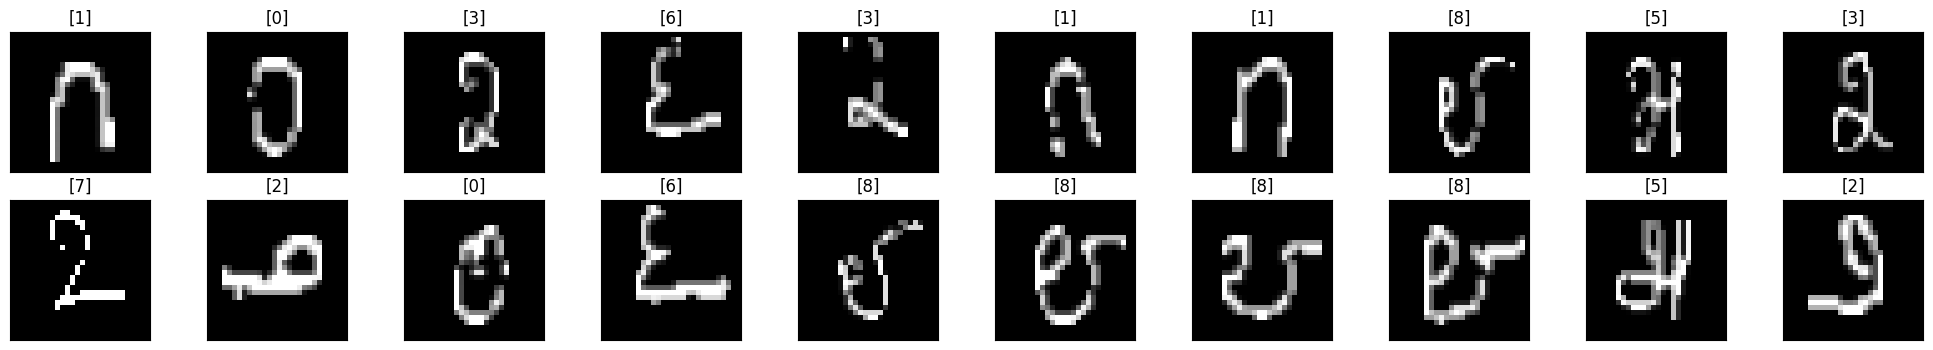

In [145]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
fig = plt.figure(figsize=(25,4))
for i in range(20):
    ax = fig.add_subplot(2, 10, i+1, xticks=[], yticks=[])
    plt.imshow(get_image(images[i]))
    ax.set_title([labels[i].item()])

In [146]:
class CNN_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,20,5,1)
        self.conv2 = nn.Conv2d(20,50,5,1)
        self.fc1 = nn.Linear(in_features=4*4*50, out_features=500)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(in_features=500, out_features=10)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x,2,2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x,2,2)
        x = x.view(-1,4*4*50)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [147]:
model = CNN_Model().to(device)
model

CNN_Model(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [148]:
criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [149]:
train_losses = []
train_accs = []
epochs = 10
for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    for images, labels in train_loader:
        #Shifting the images, and labels to GPU
        images = images.to(device)
        labels = labels.to(device)
        #Computing the model output
        train_out = model(images)
        #Computing the loss
        loss = criteria(train_out, labels)
        #Setting the gradient to 0, computing the new gradient, and updating the parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #Computing metrics
        train_loss += loss.item()
        _, preds = torch.max(train_out, 1)
        train_acc += (preds==labels.data).sum().item()
    
    train_loss = train_loss/(len(train_loader.dataset))
    train_losses.append(train_loss)
    train_acc = 100*train_acc/(len(train_loader.dataset))
    train_accs.append(train_acc)
    
    if(epoch%1==0):
        print(f"Epoch: {epoch+1}/{epochs} | Training Loss: {train_loss:.5f} | Training Accuracy: {train_acc:.4f}%")

Epoch: 1/10 | Training Loss: 0.00491 | Training Accuracy: 97.0350%
Epoch: 2/10 | Training Loss: 0.00171 | Training Accuracy: 98.9717%
Epoch: 3/10 | Training Loss: 0.00133 | Training Accuracy: 99.2217%
Epoch: 4/10 | Training Loss: 0.00106 | Training Accuracy: 99.3717%
Epoch: 5/10 | Training Loss: 0.00094 | Training Accuracy: 99.4233%
Epoch: 6/10 | Training Loss: 0.00082 | Training Accuracy: 99.5250%
Epoch: 7/10 | Training Loss: 0.00076 | Training Accuracy: 99.5800%
Epoch: 8/10 | Training Loss: 0.00072 | Training Accuracy: 99.5883%
Epoch: 9/10 | Training Loss: 0.00069 | Training Accuracy: 99.6100%
Epoch: 10/10 | Training Loss: 0.00059 | Training Accuracy: 99.6700%


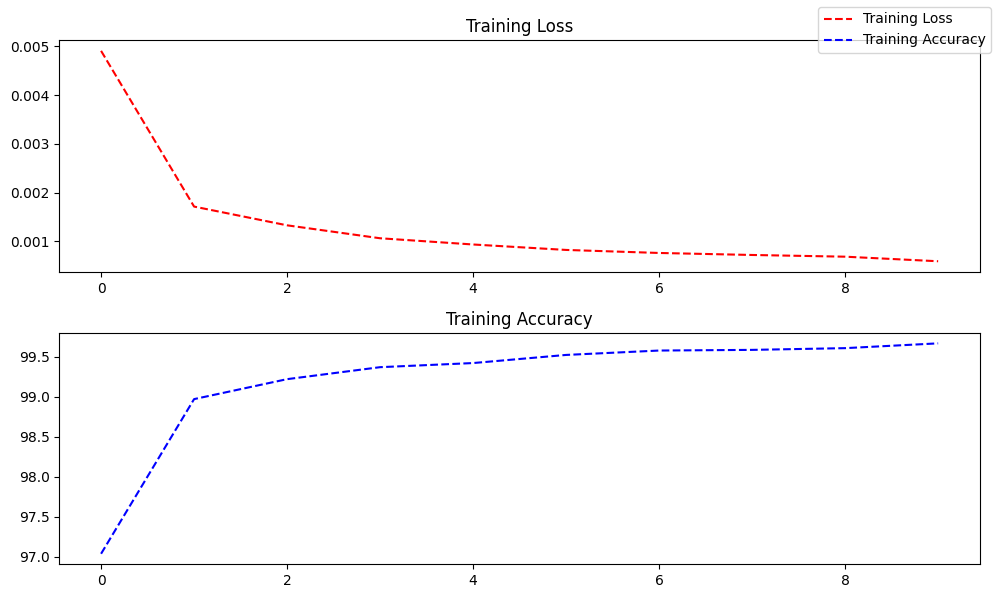

In [150]:
fig, ax = plt.subplots(2,1,figsize=(10,6))
ax[0].set_title("Training Loss")
ax[0].plot(train_losses, 'r--', label="Training Loss")
ax[1].set_title("Training Accuracy")
ax[1].plot(train_accs, 'b--', label="Training Accuracy")
fig.legend()
plt.tight_layout()

In [162]:
test_acc = 0
model_preds = []
with torch.no_grad():
    for test_images, _ in test_loader:
        test_images = test_images.to(device)
        test_labels = test_labels.to(device)
        test_preds = model(test_images)
        _, preds = torch.max(test_preds, 1)
        model_preds.append(preds.cpu().detach().numpy())
    #test_acc = test_acc/len(test_loader.dataset)
    
final_preds = np.concatenate(model_preds, axis=0)
final_preds[:40]

array([3, 0, 2, 6, 7, 7, 1, 9, 3, 4, 8, 8, 1, 7, 8, 1, 5, 1, 5, 9, 3, 7,
       6, 0, 2, 0, 8, 7, 0, 0, 8, 9, 2, 3, 2, 4, 6, 0, 7, 8])

In [164]:
df = pd.read_csv("/kaggle/input/Kannada-MNIST/test.csv")
id_val = np.array(df["id"])
final_preds_dict = {"id": id_val, "label": final_preds}
df = pd.DataFrame.from_dict(final_preds_dict)
df

,id,label
0,0,3
1,1,0
2,2,2
3,3,6
4,4,7
...,...,...
4995,4995,1
4996,4996,0
4997,4997,1
4998,4998,6


In [165]:
df.to_csv("TestPredictions.csv", index=False)